In [66]:

import MDAnalysis as mda
#from MDAnalysisData import datasets
from MDAnalysis.analysis import rms, align
# import nglview as nv

import warnings

gro_file = "vars/output_no_water.gro"
xtc_file = "vars/output_no_water.xtc"
u=mda.Universe(gro_file, xtc_file)

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
rna_start = NUM_PROTEINS * PROTEIN_LEN

i = 10

start_index = rna_start + 1 + i*RNA_LEN
end_index = rna_start+(i+1)*RNA_LEN

In [72]:
import MDAnalysis as mda
from MDAnalysis.coordinates.XTC import XTCWriter
from MDAnalysis.coordinates.GRO import GROWriter


# Load the full system from GROMACS files
gro_file = "vars/output_no_water.gro"
xtc_file = "vars/output_no_water.xtc"
u = mda.Universe(gro_file, xtc_file)

# Define RNA backbone selection
backbone_sel = f"bynum {start_index}:{end_index} and (name P O5' C5' C4' C3' O3' C1' C2')"
rna_backbone = u.select_atoms(backbone_sel)
print(f"Selected {len(rna_backbone)} backbone atoms.")

# Create a new Universe for just the RNA backbone
ref_u = mda.Merge(rna_backbone)  # Creates a new universe with only the selected atoms

# Save the cleaned-up GRO file (first frame structure)
output_gro = "vars/cleaned_rna.gro"
with GROWriter(output_gro) as gro_writer:
    gro_writer.write(ref_u)

# Write a new cleaned trajectory
output_xtc = "vars/cleaned_rna.xtc"
with XTCWriter(output_xtc, n_atoms=len(rna_backbone)) as writer:
    for ts in u.trajectory:
        ref_u.atoms.positions = rna_backbone.positions  # Update the new universe positions
        writer.write(ref_u.atoms)

print(f"Cleaned trajectory saved to {output_xtc}")

Selected 175 backbone atoms.
Cleaned trajectory saved to vars/cleaned_rna.xtc


In [75]:
import warnings
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

# Load trajectory
gro_file = "vars/cleaned_rna.gro"
xtc_file = "vars/cleaned_rna.xtc"
u = mda.Universe(gro_file, xtc_file)

# Define selection for RNA backbone
backbone_sel = f"(name P O5' C5' C4' C3' O3' C1' C2')"

# Select RNA backbone atoms
rna_backbone = u.select_atoms(backbone_sel)
print(f"Selected {len(rna_backbone)} backbone atoms.")

# Compute the average structure for the RNA backbone
average = align.AverageStructure(u, u, select=backbone_sel, ref_frame=2000).run()
ref_u = average.results.universe  # Static reference structure

# Ensure the reference contains the same atoms as the selection
ref_backbone = ref_u.select_atoms(backbone_sel)
print(f"Reference selection contains {len(ref_backbone)} atoms.")

# Check for consistency
if len(ref_backbone) == 0:
    raise ValueError("Reference structure contains no selected backbone atoms. Check your selection.")

# Align trajectory to the reference structure (only RNA backbone)
aligner = align.AlignTraj(u, ref_u, select=backbone_sel, in_memory=True).run()

# Compute RMSF for the RNA backbone
c_alphas = u.select_atoms(backbone_sel)
print(f"Number of backbone atoms after alignment: {len(c_alphas)}")

R = rms.RMSF(c_alphas).run()

Selected 175 backbone atoms.
Reference selection contains 175 atoms.
Number of backbone atoms after alignment: 175


<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_1084070/714071734.py:6: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')
/tmp/ipykernel_1084070/714071734.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


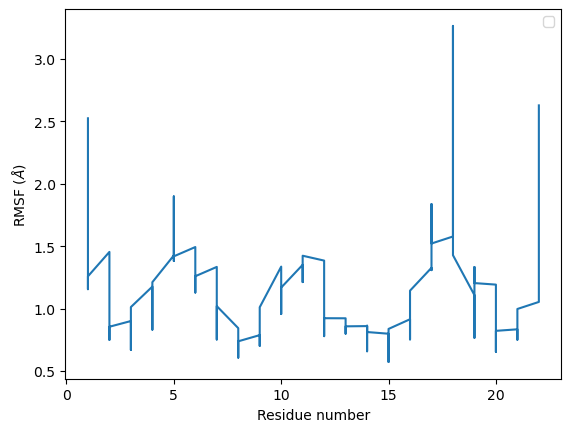

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
# plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
# plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()